In [1]:
import sys
# put mimic3 related files in MIMIC_3_DIR
import copy
from datetime import datetime
import numpy as np
import pandas as pd
from collections import defaultdict
from tqdm import tqdm
import csv
import json

import gzip

In [2]:
MIMIC_3_DIR = "/data/corpora_alpha/MIMIC/physionet.org/files/mimiciii/1.4/"

In [3]:
# load admissions
df_admission = pd.read_csv('%s/ADMISSIONS.csv.gz' % (MIMIC_3_DIR), compression='gzip', index_col=None)
print(len(set(df_admission['HADM_ID'])))
print(len(set(df_admission['SUBJECT_ID'])))

58976
46520


In [4]:
# load notes

note_dict = {}
unique_note_types = []



notes_file = '%s/NOTEEVENTS.csv.gz' % (MIMIC_3_DIR)
with gzip.open(notes_file, mode='rt') as csvfile:
    notereader = csv.reader(csvfile)
    next(notereader)
    i = 0
    for line in tqdm(notereader):
        subject_id = int(line[1])
        hadm_id = str(line[2])
        CHARTDATE = str(line[3])
        category = str(line[6]).strip().lower()
        note = line[10]
        if (subject_id, hadm_id) not in note_dict:
            note_dict[(subject_id, hadm_id)] = []
        if category == "discharge summary":
            note_dict[(subject_id, hadm_id)].append(CHARTDATE + " -- discharge summary --\n\n" + note)
        else:
            note_dict[(subject_id, hadm_id)].append(CHARTDATE + " -- "+ category + " note --\n\n" + note)
        if not category in unique_note_types:
            unique_note_types.append(category)
        i += 1

0it [00:00, ?it/s]

2083180it [01:12, 28650.47it/s]


In [5]:
unique_note_types

['discharge summary',
 'echo',
 'ecg',
 'nursing',
 'physician',
 'rehab services',
 'case management',
 'respiratory',
 'nutrition',
 'general',
 'social work',
 'pharmacy',
 'consult',
 'radiology',
 'nursing/other']

In [6]:
# number of notes
num_notes = 0
for k, v in note_dict.items():
    num_notes += len(v)
print(num_notes)

2083180


In [7]:
# preprocess
import re
def proc_text(text):
    text = re.sub(r'\[\*\*[^\]]*\*\*\]', '', text)  # remove any mimic special token like [**2120-2-28**] or [**Hospital1 3278**]
    text = re.sub('Dr\.','doctor',text)
    text = re.sub('dr\.','doctor',text)
    text = re.sub('M\.D\.','doctor',text)
    text = re.sub('--|__|==','',text)
    step1 = re.sub("\r", "\n", text)
    step2 = re.sub(r'(?<!\n)\n(?!\n)', ' ', step1) # Replace single \n with a space
    text = re.sub(r'\n{2,}', '\n', step2) # Collapse multiple \n into a single \n
    return re.sub(r'  +', ' ', text)

In [8]:
def convert_to_date(string):
    date_str = string[:10]  # Extract the first 10 characters as the date
    return datetime.strptime(date_str, "%Y-%m-%d")

note_dict_tmp = {}
hadmid2prevhadmid = defaultdict(list)

for (subject_id, hadm_id), v in note_dict.items():
    sorted_notes = sorted(v, key=lambda item: convert_to_date(item))
    if len(sorted_notes) > 0:
        note_dict_tmp[(subject_id, hadm_id)] = proc_text("\n\n".join(sorted_notes))




In [9]:
sorted_notes

['2148-07-25 -- nursing/other note --\n\nNeonatology\nBaby Girl [**Known lastname 1672**] is a newborn infant referred by Dr. [**Last Name (STitle) 2252**] for evaluation of sepsis risk.\n\nShe was born at 8:29 pm this evening as the 3150 gm product of a 39 3/7 weeks gestation pregnancy to a 31 y.o. G1 P0-1 mother with [**Name (NI) 44**] [**2148-7-29**].  Prenatal labs included BT O+/Ab-, RPR NR, RI, HBsAg-, and GBS+.  Pregnancy was notable for zoster illness at 24 weeks but was otherwise reportedly uncomplicated.  Intrapartum course was notable for ROM 10 hrs PTD, maternal treatment with abx beginning 9.5 hrs PTD, and maternal temp to 100.4.  Infnat was born via c-section due to NRFHT with meconium stained fluid, and emerged vigorous with Apgars [**8-29**].  Due to sepsis risk factors, infant was brought to NICU.\n\nExam:\nWt 3150 gm.\nVS: T 99.9 R, HR 150s, RR 40s, BP pending.\nGen: active and vigorous, WD, no distress.\nSkin: warm, dry, pink, no rash.\nHEENT: fontanelles soft and fl

In [10]:
len(note_dict_tmp)

82178

In [11]:
note_dict = note_dict_tmp

In [12]:
# test_hadm_ids = []

# readmi_test = "~/mimic3/ICD-MSMN/sample_data/mimic3_readmit/discharge/test.csv"
# df_tmp = pd.read_csv(readmi_test)
# test_hadm_ids += [str(int(a)) for a in df_tmp.ID.tolist()]
# readmi_test = "~/mimic3/ICD-MSMN/sample_data/mimic3_readmit/discharge/val.csv"
# df_tmp = pd.read_csv(readmi_test)
# test_hadm_ids += [str(int(a)) for a in df_tmp.ID.tolist()]
# readmi_test = "~/mimic3/ICD-MSMN/sample_data/mimic3_prevvisit/test_full.csv"
# df_tmp = pd.read_csv(readmi_test)
# test_hadm_ids += [str(a) for a in df_tmp.HADM_ID.tolist()]
# readmi_test = "~/mimic3/ICD-MSMN/sample_data/mimic3_prevvisit/dev_full.csv"
# df_tmp = pd.read_csv(readmi_test)
# test_hadm_ids += [str(a) for a in df_tmp.HADM_ID.tolist()]

# test_hadm_ids =set(test_hadm_ids)

In [13]:
# split pretraning and testing data

with open('./test_hadm_ids.json', 'r') as f:
    test_hadm_ids = json.load(f)
print(len(test_hadm_ids))

train_data = {}
test_data = {}
for (subject_id, hadm_id), v in note_dict.items():
    if hadm_id in test_hadm_ids:
        test_data[(subject_id, hadm_id)] = v
    else:
        train_data[(subject_id, hadm_id)] = v

print(len(train_data))
print(len(test_data))

6049
76129
6049


In [15]:
from transformers import AutoTokenizer
from langchain.text_splitter import CharacterTextSplitter
tokenizer = AutoTokenizer.from_pretrained("/data/data_user_alpha/public_models/state-spaces-mamba/mamba-130m")
max_tokens = 16384
text_splitter = CharacterTextSplitter.from_huggingface_tokenizer(
    tokenizer, chunk_size=max_tokens-5, chunk_overlap=0
)

train_data_new = []
for (subject_id, hadm_id), notes in train_data.items():
    texts = text_splitter.split_text(notes)
    data_tmp = {}
    i = 0
    for texta in texts:
        data_tmp["subjectid"] = subject_id
        data_tmp["hadmid"] = hadm_id
        data_tmp["segid"] = i
        data_tmp["notes"] = texta
        i += 1
    train_data_new.append(data_tmp)
train_data = train_data_new

test_data_new = []
for (subject_id, hadm_id), notes in test_data.items():
    texts = text_splitter.split_text(notes)
    data_tmp = {}
    i = 0
    for texta in texts:
        data_tmp["subjectid"] = subject_id
        data_tmp["hadmid"] = hadm_id
        data_tmp["segid"] = i
        data_tmp["notes"] = texta
        i += 1
    test_data_new.append(data_tmp)
test_data = test_data_new

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [16]:
print(max_tokens)

16384


In [18]:
# save
with open('data_train_16384.json', 'w') as fp:
    fp.write('\n'.join(json.dumps(i) for i in train_data))
with open('data_test_16384.json', 'w') as fp:
    fp.write('\n'.join(json.dumps(i) for i in test_data))


print(len(train_data))
print(len(test_data))

76129
6049


In [6]:
# tokenizer
from transformers import AutoTokenizer

note_dict = []
with open("/home/zhichaoyang/mimic3/clinical-mamba/preprocess/data_train.json", "r") as file:
    for line in file:  
        note_dict.append(json.loads(line))
tokenizer = AutoTokenizer.from_pretrained("/data/data_user_alpha/public_models/state-spaces-mamba/mamba-130m")

num_tokens = []
for (subject_id, hadm_id), v in note_dict:
    tokens = tokenizer(v)["input_ids"]
    num_tokens.append(len(tokens))

num_tokens = np.array(num_tokens)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [7]:
#train statistics
print(num_tokens.sum())
print(num_tokens.mean())
print(np.percentile(num_tokens,99.9))
print(np.percentile(num_tokens,99))
print(np.percentile(num_tokens,95))
print(np.percentile(num_tokens,50))
print(np.percentile(num_tokens,1))
print(num_tokens.min())

763894341
10034.209578478634
312460.5760000006
100422.20000000007
35258.19999999998
4533.0
50.0
14


In [5]:
#test statistics
print(num_tokens.sum())
print(num_tokens.mean())
print(np.percentile(num_tokens,99.9))
print(np.percentile(num_tokens,99))
print(np.percentile(num_tokens,95))
print(np.percentile(num_tokens,50))
print(np.percentile(num_tokens,1))
print(num_tokens.min())

113801842
18813.331459745412
441370.8640000027
190458.4799999973
68774.19999999994
7513.0
1637.92
575


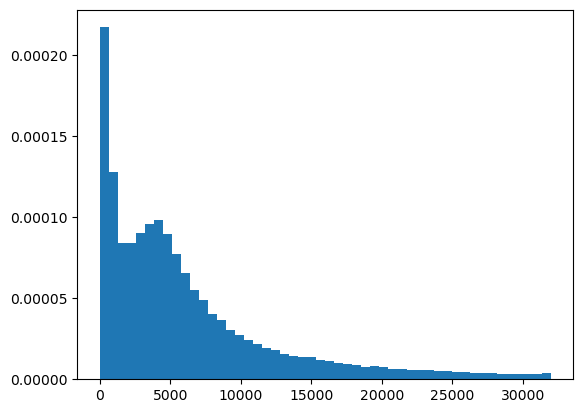

In [22]:
import matplotlib.pyplot as plt
filtered_data = num_tokens[num_tokens < 32000]
n, bins, patches = plt.hist(filtered_data, bins=50, density=True)
plt.show()